In [12]:
import time
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score, roc_curve
import torch
import torch.nn.functional as F
import numpy as np
from xgnn_src.shared_networks import OnlineKG, NaiveTeacher
from xgnn_src.graph.gcn import GCN, GCN_MLP
from xgnn_src.graph.utils import load_data
import pickle as pkl
from sklearn.model_selection import StratifiedKFold
from xgnn_src.graph.dataloader import GCDataLoader
from xgnn_src.graph.utils import draw_mutag, get_mask

In [13]:
import collections
import dgl
import networkx as nx
import matplotlib.pyplot as plt

In [14]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8, 8]

- Don't use balancing weight for class
- Select Mutagenicity graphs w/ NO2 & NH2 & randomly select the same number of graphs for negative (downsampling)

python online_kd.py --dataset Mutagenicity --device 0 --graph_pooling_type max 
--model_name gcn --linear_pooling_type last --epochs 200 --kd_strategy naive 
--norm_type bn  --store_data ./ckpt/gcn/pgmutag_rand08.dat --datapath ./datasets/dgl_mutagenicity.pkl --split_name rand --split_ratio 0.8 --lr 0.01 --beta 5. --mk_term 0.001 --sl_term 0.0001 --model_path ./ckpt/gcn/pgmutag_rand5.pt



In [15]:
def get_mask(g, base, explainer, undir=True, threshold=0.5):
    base.eval()
    explainer.eval()
    with torch.no_grad():
        base(g, g.ndata['attr'])
        embedding = g.ndata['emb']
        edge_weight = explainer.edge_mask.compute_adj(g, embedding)
        edge_weight = explainer.edge_mask.edge_mlp(edge_weight)
        mask = explainer.edge_mask.concrete(edge_weight, beta=5.)
#         print(mask)
#         mask = F.sigmoid(edge_weight)
#         print(mask)
    with g.local_scope():
        num_nodes = g.num_nodes()
        adj = [[0.] * num_nodes for _ in range(num_nodes)] 
        src, dst = g.edges()
        for i, (s, d) in enumerate(zip(src, dst)):
            s, d = s.item(), d.item()
            m = mask[i].item()
            if m < threshold:
                adj[s][d] = 0.0
                if undir:
                    continue
                adj[d][s] = 0.0
            else:
                adj[s][d] = m
        weight = []
        for s, d in zip(src, dst):
            s, d = s.item(), d.item()
            weight.append(adj[s][d])
        mask = np.array(weight)
    return mask

In [16]:
def obtain_predictions(tpr, fpr, threshold, preds):
    optimal_proba_cutoff = sorted(zip(tpr - fpr, threshold), key=lambda i: i[0], reverse=True)[0][1]
    roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in preds]
    return roc_predictions

In [17]:
mutag_labels = ['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']

In [18]:
base = GCN(14, 64, 2, 5, 0.0, 'max', 'last')
explainer = GCN_MLP(14, 64, 2, 5, 0.5, 64 * 2, 'max', 'last', 'sigmoid', False, 'bn', 0.0)
teacher = NaiveTeacher(2, 'mean')
online_mode = OnlineKG(base, explainer, teacher)
model = torch.load('./graph/ckpt/gcn/pgmutag_rand5.pt')
online_mode.load_state_dict(model)

norm type: bn
norm type: bn


<All keys matched successfully>

In [20]:
dataset, dim_nfeats, gclasses = load_data('Mutagenicity', './graph/datasets/dgl_mutagenicity.pkl', neg_ratio=1.)

In [21]:
graphs = []
for g, l in dataset:
    if l == 0 and g.edata['edge_labels'].sum() > 0:
        graphs.append(g)

In [ ]:
preds = []
for g in graphs:
    weight = get_mask(g, base, explainer, True, threshold=0.5)
    pred = torch.ceil(torch.tensor(weight)).to(torch.int64).numpy()
    real = g.edata['edge_labels'].numpy()
    pred = precision_score(real, pred)
    preds.append(pred)
preds = torch.tensor(preds)

In [134]:
print(torch.topk(preds, 100).indices[:50])

tensor([169, 420, 975, 645, 791, 681, 518, 414, 203, 322, 701, 498, 153,  82,
        462, 761, 752, 421, 718, 720, 732, 719, 724, 682, 680, 679, 678, 677,
        676, 675, 674, 673, 747, 738, 717, 735, 734, 733, 737, 741, 742, 743,
        744, 745, 746, 721, 740, 731, 730, 729])


***Ground truth***

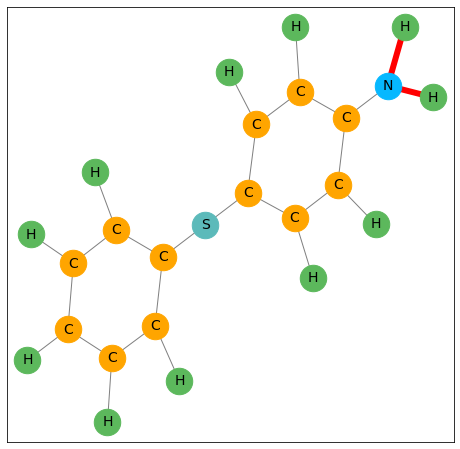

In [29]:
gid = 257
g = graphs[gid]
real = g.edata['edge_labels'].numpy()
weight2 = real * 5 + 1
src, dst = g.edges()
draw_mutag(g, weight2.tolist(), undir=True, node_size=700, margin=0.05)
plt.savefig("./graph/images/important_subgraphs2/mutag/mutag_%i_real.pdf"%gid, format='pdf', dpi=300)

0.6666666666666666 1.0


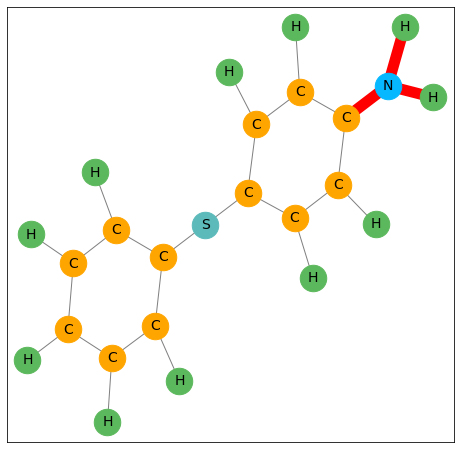

In [145]:
gid = 257
g = graphs[gid]
weight = get_mask(g, base, explainer, True, threshold=0.5)
weight2 = np.array(weight * 10 + 1).astype(np.int)
pred = torch.ceil(torch.tensor(weight)).to(torch.int64).numpy()
real = g.edata['edge_labels'].numpy()
print(precision_score(real, pred), recall_score(real, pred))
src, dst = g.edges()
i = 0
draw_mutag(g, weight2.tolist(), undir=True, node_size=700, margin=0.05)
plt.savefig("./graph/images/important_subgraphs2/mutag/mutag_%i.pdf"%gid, format='pdf', dpi=300)
# for s, d, r, p, w in zip(src, dst, real, pred, weight2):
#     if w > 1:
#         s, d = s.item(), d.item()
#         sl, dl = mutag_labels[g.ndata['node_labels'][s]], mutag_labels[g.ndata['node_labels'][d]]
#         print("check",i, s, d, sl, dl, r, p, w)
#     i += 1

In [111]:
gx = dgl.to_networkx(g)
print(gx.edges())

[(0, 1), (0, 2), (0, 3), (1, 0), (1, 4), (1, 5), (2, 0), (2, 6), (2, 12), (3, 0), (3, 7), (3, 13), (3, 14), (4, 1), (4, 8), (4, 15), (5, 1), (5, 16), (6, 2), (6, 9), (6, 8), (7, 3), (7, 10), (7, 17), (7, 18), (8, 4), (8, 11), (8, 6), (9, 6), (9, 19), (10, 7), (10, 20), (10, 21), (11, 8), (11, 22), (12, 2), (13, 3), (14, 3), (15, 4), (16, 5), (17, 7), (18, 7), (19, 9), (20, 10), (21, 10), (22, 11)]


In [112]:
g.edges()

(tensor([ 0,  1,  0,  2,  0,  3,  1,  4,  1,  5,  2,  6,  3,  7,  4,  8,  6,  9,
          7, 10,  8, 11,  6,  8,  2, 12,  3, 13,  3, 14,  4, 15,  5, 16,  7, 17,
          7, 18,  9, 19, 10, 20, 10, 21, 11, 22]),
 tensor([ 1,  0,  2,  0,  3,  0,  4,  1,  5,  1,  6,  2,  7,  3,  8,  4,  9,  6,
         10,  7, 11,  8,  8,  6, 12,  2, 13,  3, 14,  3, 15,  4, 16,  5, 17,  7,
         18,  7, 19,  9, 20, 10, 21, 10, 22, 11]))

In [15]:
src, dst = g.edges()
idx1 = g.edata['edge_labels'].nonzero().flatten()
s1, d1 = src[idx1], dst[idx1]
idx2 = pred.nonzero().flatten()
s2, d2 = src[idx2], dst[idx2]
print(s1,d1)
print(s2,d2)

tensor([11, 14, 11, 15]) tensor([14, 11, 15, 11])
tensor([ 7, 11, 11, 14, 11, 15]) tensor([11,  7, 14, 11, 15, 11])


In [19]:
g.nodes[11].data['node_labels']

tensor([4], dtype=torch.int32)

In [11]:
s = time.time()
reals, preds = [], []
for g in graphs:
    weight = get_mask(g, base, explainer, True, threshold=0.0)
    label = g.edata['edge_labels'].numpy()
    fpr, tpr, threshold = roc_curve(label, weight)
    pred = obtain_predictions(tpr, fpr, threshold, weight)    
    reals.extend(label)
    preds.extend(pred)

pr = precision_score(reals, preds)
re = recall_score(reals, preds)
f1 = 2 * pr * re / (pr + re)
print("Precision %.4f, Recall %.4f F1 %.4f" % (pr, re, f1))
print(time.time() - s)

Precision 0.6617, Recall 0.9972 F1 0.7955
6.670144081115723
